In [160]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

In [161]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpi
%matplotlib inline

In [162]:
import glob
import tqdm
from copy import copy

In [163]:
def fit_pca(X, n_comp):
    pca = PCA(n_components=n_comp)
    return pca.fit(X)

def fit_svm(X, y, C, gamma):
    svm = SVC(C = C, random_state=241, gamma=gamma)
    return svm.fit(X, y)

def fit_pca_svm(X, y, n_comp=100, C = 2, gamma=0.0001):
    pca = fit_pca(X, n_comp=n_comp)
    smv = fit_svm(pca.transform(X), y, C = C, gamma=gamma)
    return (pca, svm)

def fit_get_score_pca_svm(X, y, X_test, y_test, n_comp = 500, C = 2, gamma =0.001):
    pca = fit_pca(X, n_comp=n_comp)
    X_tr = pca.transform(X)
    X_test_tr = pca.transform(X_test)
    print(pca.explained_variance_ratio_[:min(n_comp, 20)])
    
    svm = fit_svm(X_tr, y, C = C, gamma = gamma)
    print(svm)
    print('support vectors count:', len(svm.support_))
    print('train score:', accuracy_score(y, svm.predict(X_tr)))
    print('test score:', accuracy_score(y_test, svm.predict(X_test_tr)))
    
    return (pca, svm)

def get_score_pca_svm(pca, svm, X, y):
    X_tr = pca.transform(X)
    y_pred = svm.predict(X_tr)
    print(y_pred)
    print(accuracy_score(y_pred, [4 if y_o == 'v' else ord(y_o) - ord('a') for y_o in y]))
    return accuracy_score(y, y_pred)

letters = {}
from string import ascii_lowercase
for c in ascii_lowercase:
    letters[c] = c;
del letters['j']
del letters['z']
letters = sorted(list(letters))
LETTERS_TO_ANALYSE = 5

In [175]:
def convert_size_for_dataset1(image):
    h = image.shape[0]
    w = image.shape[1]
    if h > w:
        if (w/h > 0.8):
            k = int((h - w) / 2)
            image = image[k:-k-1, :]
        else:
            image = image[int(0.1*h): -int(0.1*h)-1, :]
    if h < w:
        if (h/w > 0.8):
            k = int((w - h) / 2)
            image = image[:, k:-k-1]
        else:
            image = image[:, int(0.1*h): -int(0.1*h)-1]
    image = cv2.resize(image, (128, 128))

In [199]:
def collectImages_for_dataset1(letter):
    speakers = ['A', 'B', 'C', 'D', 'E']
    path = 'dataset1/'
    data = []
    for s in speakers:
        image_path = path + s + '/' + letter + '/'
        names = glob.glob(image_path + "*.*")
        for name in names:
            image = cv2.imread(name)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = convert_size_for_full_dataset(image)
            data.append(image)
    return data

def precountSize(letters):
    speakers = ['A', 'B', 'C', 'D', 'E']
    result = 0
    for l in letters:
        for s in speakers:
            image_path = 'dataset1/' + s + '/' + l + '/'
            names = glob.glob(image_path + "*.*")
            result += len(names)
    return result

In [167]:
hog_descriptor = cv2.HOGDescriptor((128, 128), #winsize
                                    (16, 16), #blocksize
                                    (8, 8), #blockstride
                                    (8, 8),   #cellsize
                                    9)        #nbins
HOGSIZE = 8100

In [169]:
def collect_from_datasets(letters):
    X = []
    Y = []
    cur = 0
    data1 = collectImages(letters)    
    for Im in Ldata:
        X.append(hog_descriptor.compute(Im))
        Y.append(4 if i == 'v' else ord(i) - ord('a')) #need to replace
        cur += 1
    X = np.array(X)
    Y = np.array(Y)
    random_order = np.random.permutation(X.shape[0])
    x_shuffle = []
    y_shuffle = []
    for i in random_order:
        x_shuffle.append(X[i])
        y_shuffle.append(Y[i])
    X = np.array(x_shuffle) 
    Y = np.array(y_shuffle)
    X = X.reshape((X.shape[0], X.shape[1]))
    Y = Y.reshape((Y.shape[0]))
    split = int(round(0.2*len(Y)))
    x_train = X[split:]
    y_train = Y[split:]
    x_test = X[:split]
    y_test = Y[:split]
    del x_shuffle
    del y_shuffle
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1]))

In [170]:
def filter_other_data(X, Y):
    X_filter, y_filter = [], []
    for x, y in zip(X, Y):
        y_lower = y.lower()
        if (y_lower in ['a', 'b', 'c', 'v']):
            X_filter.append(x)
            y_filter.append(y_lower)
    return X_filter, y_filter

    from os import listdir, walk
    from os.path import isfile, join
    def take_all_pictures_names(path):
        paths = []
        targets = []
        for x in walk(path):
            for y in x[2]:
                if (y.find('depth') == -1):
                    paths.append(x[0] + '/' + y)
                    targets.append(x[0][len(x[0]) - 1:])
        return paths, targets

    def get_all_pictures(path, a, b):
        X = []
        y = []
        names, targets = take_all_pictures_names(path)
        for ind, (name, target) in enumerate(zip(names, targets)):
            if (ind >= a and ind < b):
                X.append(cv2.cvtColor(cv2.imread(names[i]), cv2.COLOR_BGR2RGB))
                y.append(target)
        return X, y

    def get_pictures_in_range(path, ind_range):
        X = []
        y = []
        names, targets = take_all_pictures_names(path)
        count = 0
        print('all_pictures on disk:', len(names))
        for i in ind_range:
            X.append(cv2.cvtColor(cv2.imread(names[i]), cv2.COLOR_BGR2RGB))
            y.append(targets[i])
            count += 1
            if (count % 500 == 0):
                print(count)
        return X, y

    def get_need_pictures_in_range(path, ind_range, need_list):
        X = []
        y = []
        names, targets = take_all_pictures_names(path)
        count = 0
        print('all_pictures on disk:', len(names))
        for i in ind_range:
            if (targets[i] in need_list):
                X.append(cv2.cvtColor(cv2.imread(names[i]), cv2.COLOR_BGR2RGB))
                y.append(targets[i])
                count += 1
                if (count % 500 == 0):
                    print(count)
        return X, y

    #Показать картинку
    def show_picture(number):
        print(y[number], X[number].shape)
        plt.imshow(X[number])


In [172]:
def clear_background_precise(image):
    imghsv = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    filter_from = np.array([110,80,80])
    filter_to = np.array([150,255,255])
    filtered = cv2.inRange(imghsv, filter_from, filter_to)
    kernel_square = np.ones((8,8),np.uint8)
    kernel_ellipse= cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    dilation = cv2.dilate(filtered,kernel_ellipse,iterations = 1)
    erosion = cv2.erode(dilation,kernel_square,iterations = 1)    
    dilation2 = cv2.dilate(erosion,kernel_ellipse,iterations = 1)    
    filtered = cv2.medianBlur(dilation2,5)
    kernel_ellipse= cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(8,8))
    dilation3 = cv2.dilate(filtered,kernel_ellipse,iterations = 1)
    kernel_ellipse= cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    dilation4 = cv2.dilate(filtered,kernel_ellipse,iterations = 1)
    median = cv2.medianBlur(dilation4,5)
    ret,final = cv2.threshold(median,127,255,0)
    #-------
    BLACK = (0, 0, 0)
    for i in range(final.shape[0]):
        final[i][0] = 0
        final[i][final.shape[1] - 1] = 0
    for i in range(final.shape[1]):
        final[0][i] = 0
        final[final.shape[0] - 1][i] = 0
    im2, contours, hierarchy = cv2.findContours(copy(final),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    max_area = 0
    num = 0
    for i in range(len(contours)):
        cnt = contours[i]
        area = cv2.contourArea(cnt)
        if(area > max_area):
            max_area = area
            num = i  
    maxcnt = contours[num]
    contours[num] = np.empty((0, 1, 2))
    cv2.drawContours(final, contours, -1, BLACK, -1)
    #----------------------
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if not final[i][j]:
                image[i][j] = BLACK
    return image

In [173]:
def clear_background_rough(image):
    imghsv = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    filter_from = np.array([110,80,80])
    filter_to = np.array([150,255,255])
    filtered = cv2.inRange(imghsv, filter_from, filter_to)
    kernel_square = np.ones((8,8),np.uint8)
    kernel_ellipse= cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    dilation = cv2.dilate(filtered,kernel_ellipse,iterations = 1)
    erosion = cv2.erode(dilation,kernel_square,iterations = 1)    
    dilation2 = cv2.dilate(erosion,kernel_ellipse,iterations = 1)    
    filtered = cv2.medianBlur(dilation2,5)
    kernel_ellipse= cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(8,8))
    dilation3 = cv2.dilate(filtered,kernel_ellipse,iterations = 1)
    kernel_ellipse= cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    dilation4 = cv2.dilate(filtered,kernel_ellipse,iterations = 1)
    median = cv2.medianBlur(dilation4,5)
    ret,final = cv2.threshold(median,127,255,0)
    #-------
    BLACK = (0, 0, 0)
    for i in range(final.shape[0]):
        final[i][0] = 0
        final[i][final.shape[1] - 1] = 0
    for i in range(final.shape[1]):
        final[0][i] = 0
        final[final.shape[0] - 1][i] = 0
    im2, contours, hierarchy = cv2.findContours(copy(final),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    max_area = 0
    num = 0
    for i in range(len(contours)):
        cnt = contours[i]
        area = cv2.contourArea(cnt)
        if(area > max_area):
            max_area = area
            num = i  
    maxcnt = contours[num]
    contours[num] = np.empty((0, 1, 2))
    cv2.drawContours(final, contours, -1, BLACK, -1)
    #-----------------
    hull = cv2.convexHull(maxcnt)
    cv2.drawContours(final, [hull], -1, (255,255,255), -1)
    #----------------------
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if not final[i][j]:
                image[i][j] = BLACK
    return image

In [ ]:
pca, svm = fit_get_score_pca_svm(x_train, y_train, x_test, y_test, n_comp=100, gamma=0.1)

all_pictures on disk: 4873
500
['A' 'B' 'C' 'V' 'e' 't']
a
(550, 8100) 550 ['a' 'b' 'c' 'v']


array(['b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b',
       'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b',
       'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b',
       'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b',
       'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b',
       'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b',
       'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b',
       'b', 'b', 'b', 'b', 'b', 'b', 'b', 'v', 'v', 'v', 'v', 'v', 'v',
       'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v',
       'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v',
       'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v',
       'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v',
       'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v',
       'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v', 'v

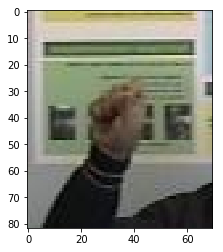

In [19]:
X_other, y_other = get_pictures_in_range('DS_5letters_train/', range(1, 4800, 5))
print(np.unique(y_other))
X_filter_other, y_filter_other = filter_other_data(X_other, y_other)
X_other = X_filter_other
y_other = y_filter_other

print(y_filter_other[300])
plt.imshow(X_filter_other[300])

size = 128
X_other = np.array([cv2.resize(x, (size, size)) for x in X_other])
X_other_p = X_other.reshape((len(X_other), size * size * 3))
X_other_p = np.array([hog_descriptor.compute(Im) for Im in X_other])
X_other_p = X_other_p.reshape((X_other_p.shape[0], X_other_p.shape[1]))
y_other = np.array(y_other)
print(X_other_p.shape, len(y_other), np.unique(y_other))

In [ ]:
get_score_pca_svm(pca, svm, X_other_p, y_other)

/home/grach/.virtualenvs/cv/lib/python3.5/site-packages/ipykernel_launcher.py:2: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  


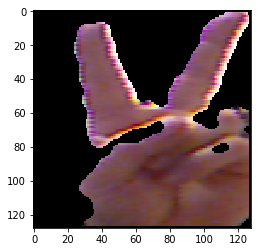

In [195]:
#Im == cv2.resize(cv2.cvtColor(cv2.imread("DS_5letters_train/A/A-train23.jpg"), cv2.COLOR_BGR2RGB), (128, 128))
Im == cv2.cvtColor(cv2.imread("DS_5letters_train/A/A-train25.jpg"), cv2.COLOR_BGR2RGB)
Im == clear_background_rough(Im)
plt.imshow(Im)

In [197]:
speakers1 = ['A', 'B', 'C', 'D', 'E']
speakers2 = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
letters = ['a', 'c', 'h', 'v', 'y']